# BUILDING ML MODEL TO PREDICT SEPSIS

> ## BUSINESS UNDERSTANDING


Sepsis, a life-threatening condition, arises from the body's exaggerated response to an infection, causing widespread inflammation, organ damage, and potential organ failure. Prompt medical intervention is essential, as sepsis is often triggered by various infections. Symptoms encompass fever, rapid heart rate, breathing difficulties, low blood pressure, and altered mental status. Treatment entails antibiotics, intravenous fluids, and supportive care. Early detection is paramount for a favorable prognosis.

This project centers on the early detection and classification of sepsis, a pivotal aspect of healthcare. Timely identification markedly improves patient outcomes. The objective is to construct a robust machine learning model for sepsis classification and deploy it as a web application using FastAPI, facilitating real-time predictions.


#### Goal:
build a ml model to predict sepsis

#### Null hypothesis:
The mean Plasma glucose level (PRG) is not significantly different between patients who develop sepsis during their ICU stay and those who do not.

#### Alternative Hypothesis:

The mean Plasma glucose level (PRG) is significantly different between patients who develop sepsis during their ICU stay and those who do not.


#### Analytical Questions
1. What is the average Plasma glucose level (PRG) among patients who develop sepsis compared to those who do not?
2. Are there any significant differences in Blood Pressure (PR), Body mass index (M11), or age between patients who develop sepsis and those who do not?
3. What is the prevalence of sepsis among the patient population, & identify factors contributing to the tendency of developing sepsis?
4. Is there a significant correlation between a patient's body mass and their susceptibility to sepsis, and can body mass be considered a potential risk factor for sepsis development?



> ## DATA UNDERSTANDING


- ID: number to represent patient ID
- PRG: Plasma glucose
- PL: Blood Work Result-1 (mu U/ml)
- PR: Blood Pressure (mm Hg)
- SK: Blood Work Result-2 (mm)
- TS: Blood Work Result-3 (mu U/ml)
- M11: Body mass index (weight in kg/(height in m)^2
- BD2: Blood Work Result-4 (mu U/ml)
- Age: patients age (years)
- Insurance: If a patient holds a valid insurance card
- Sepsis: Positive: if a patient in ICU will develop a sepsis , and Negative: otherwise


### 1. Importations 

In [7]:
%pip install xgboost
%pip install Jinja2
%pip install nbformat --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Data manipulation packages
import pandas as pd
import numpy as np

#Data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Handling class imbalance by oversampling
from imblearn.over_sampling import SMOTE 

# Models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_auc_score,roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Other Packages
import warnings
warnings.filterwarnings("ignore")

import joblib
import os

### 2. Loading datasets

In [9]:
#Load the test dataset
test_dataset= pd.read_csv('datasets/Paitients_Files_Test.csv')
test_dataset.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0


In [10]:
#Load train dataset
train_dataset= pd.read_csv('datasets/Paitients_Files_Train.csv')
train_dataset.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


### 3. Exploratory Data Analysis

In [11]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [12]:
train_dataset.columns

Index(['ID', 'PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance',
       'Sepssis'],
      dtype='object')

In [13]:
#Check for duplicated rows
train_dataset.duplicated().sum()

0

In [14]:
# check unique values 
unique_values_per_column = train_dataset.apply(pd.unique)
print(unique_values_per_column)

ID           [ICU200010, ICU200011, ICU200012, ICU200013, I...
PRG          [6, 1, 8, 0, 5, 3, 10, 2, 4, 7, 9, 11, 13, 15,...
PL           [148, 85, 183, 89, 137, 116, 78, 115, 197, 125...
PR           [72, 66, 64, 40, 74, 50, 0, 70, 96, 92, 80, 60...
SK           [35, 29, 0, 23, 32, 45, 19, 47, 38, 30, 41, 33...
TS           [0, 94, 168, 88, 543, 846, 175, 230, 83, 96, 2...
M11          [33.6, 26.6, 23.3, 28.1, 43.1, 25.6, 31.0, 35....
BD2          [0.627, 0.351, 0.672, 0.167, 2.288, 0.201, 0.2...
Age          [50, 31, 32, 21, 33, 30, 26, 29, 53, 54, 34, 5...
Insurance                                               [0, 1]
Sepssis                                   [Positive, Negative]
dtype: object


In [15]:
# Display summary statistics
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


#### Univariate analysis

In [16]:
sep_df=train_dataset['Sepssis'].value_counts(normalize=True)
sep_df

Sepssis
Negative    0.652755
Positive    0.347245
Name: proportion, dtype: float64

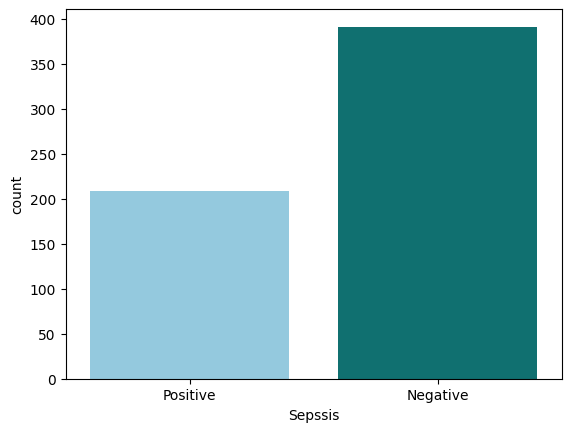

In [17]:
sns.countplot(data=train_dataset, x='Sepssis', palette=['skyblue', 'teal'])
plt.show()

In [18]:
sep_df=train_dataset['Insurance'].value_counts(normalize=True)
sep_df

Insurance
1    0.686144
0    0.313856
Name: proportion, dtype: float64

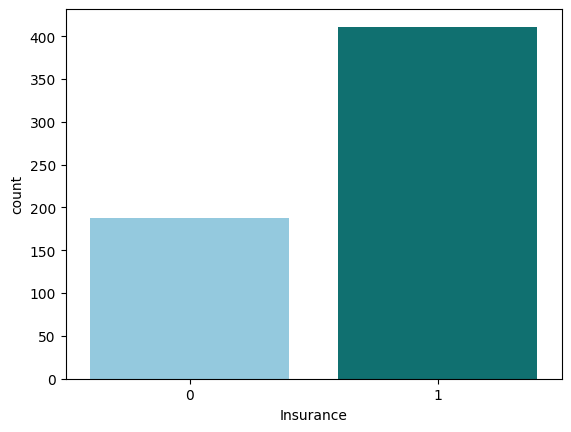

In [19]:
sns.countplot(data=train_dataset, x='Insurance', palette=['skyblue', 'teal'])
plt.show()

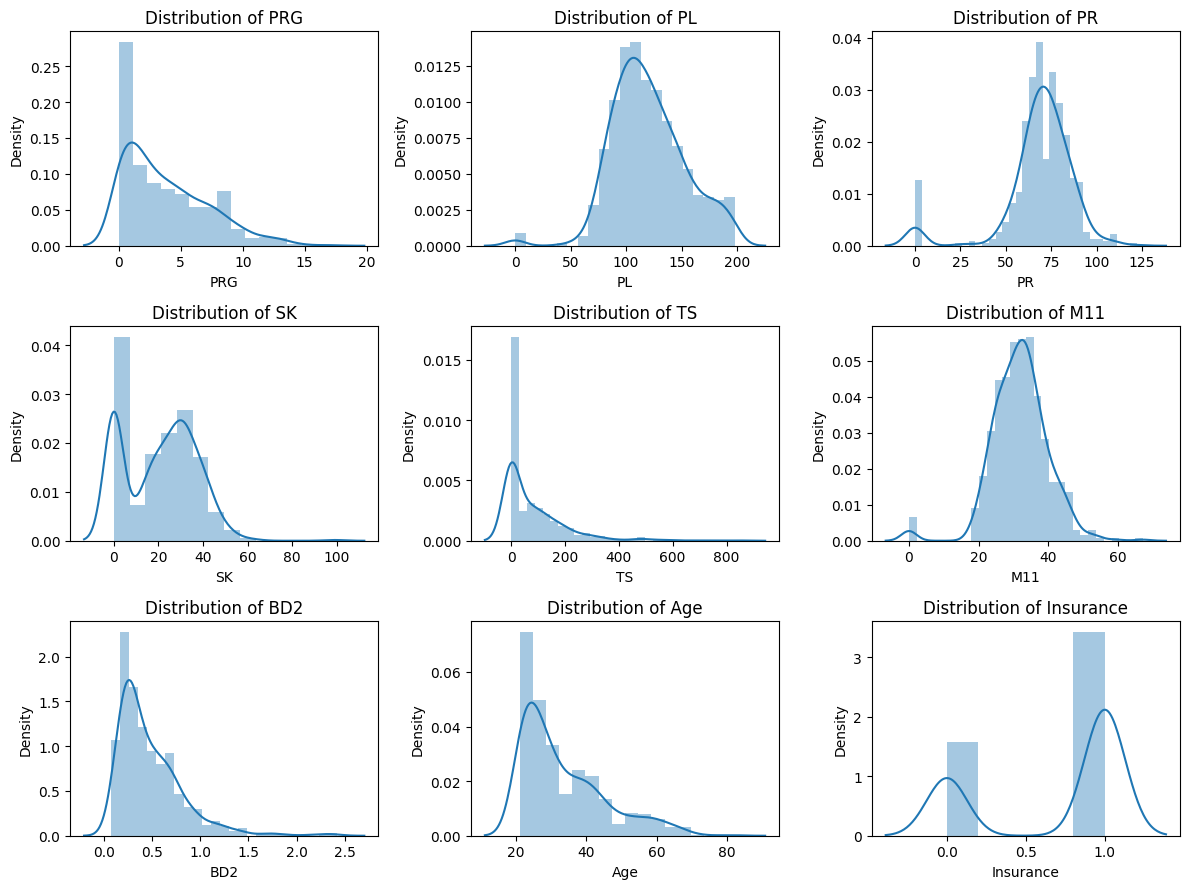

In [20]:
cols = [ 'PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']

# Calculate the number of rows and columns for subplots
num_cols = 3
num_rows = (len(cols) + num_cols - 1) // num_cols  

# Set up subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))

# Plot histograms for specific columns
for i, col in enumerate(cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    sns.distplot(train_dataset[col], kde=True,ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Distribution of {col}')
    axes[row_idx, col_idx].set_xlabel(col)
    axes[row_idx, col_idx].set_ylabel('Density')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


#### the type of distributions shown
1. Right-skewed distributions: PRG, PL, and PR have distributions skewed to the right. This means there are more data points on the left side of the distribution, with a tail extending towards higher values on the right.
2. Symmetrical distributions: SK ,M11 and TS appear to have symmetrical distributions. This suggests the data for these variables is balanced around a central point, resembling a bell-shaped curve.
3. Center of distributions: The distribution of Age is centered around 50, indicating that most ages fall around this value. Similarly, the distribution of Insurance is centered around 0.5, suggesting most insurance values cluster around this point.

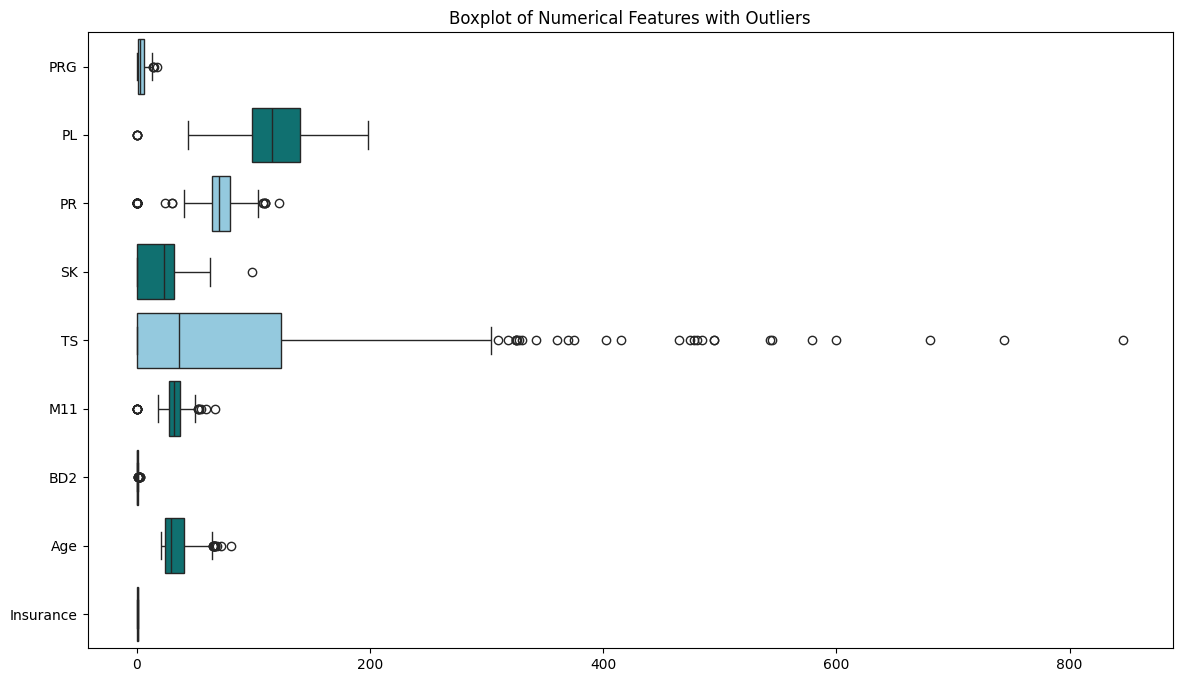

In [21]:
# Create a single boxplot to show outliers
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=train_dataset[cols], whis=1.5, orient='h', palette=['skyblue', 'teal'])
plt.title("Boxplot of Numerical Features with Outliers")
plt.show()

Number of outliers in PRG: 4


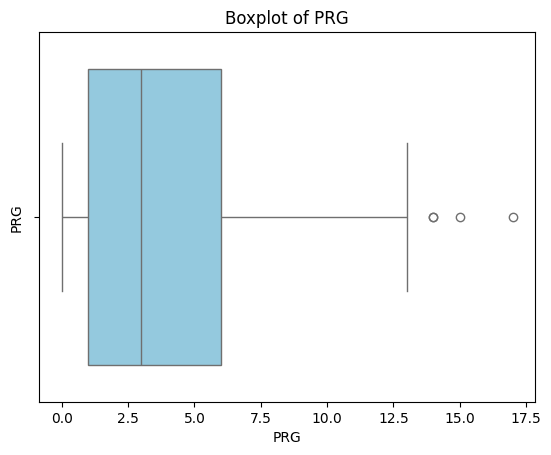

Number of outliers in PL: 0


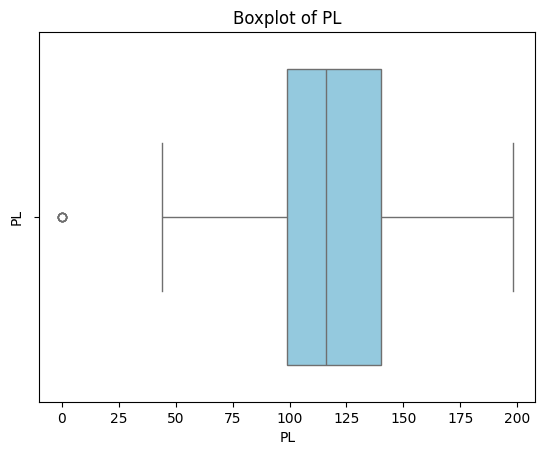

Number of outliers in PR: 6


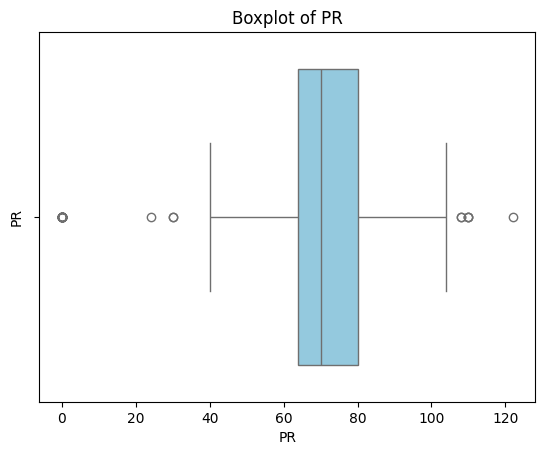

Number of outliers in SK: 1


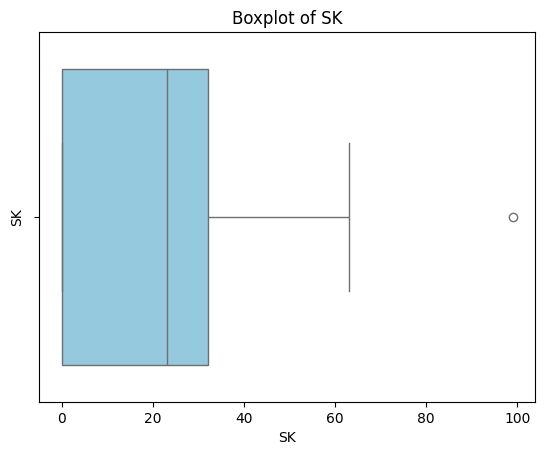

Number of outliers in TS: 28


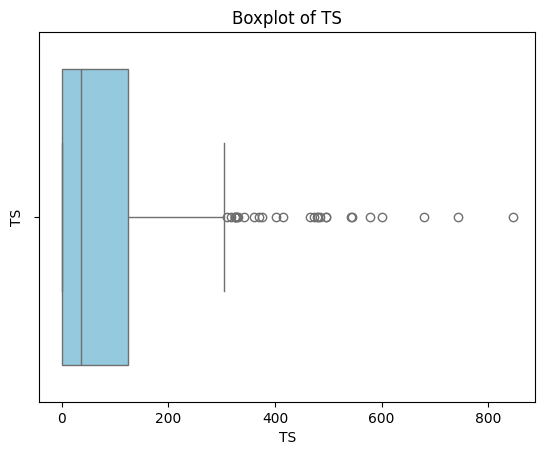

Number of outliers in M11: 7


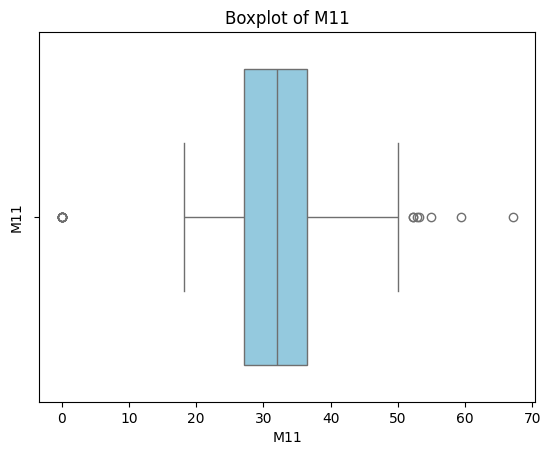

Number of outliers in BD2: 19


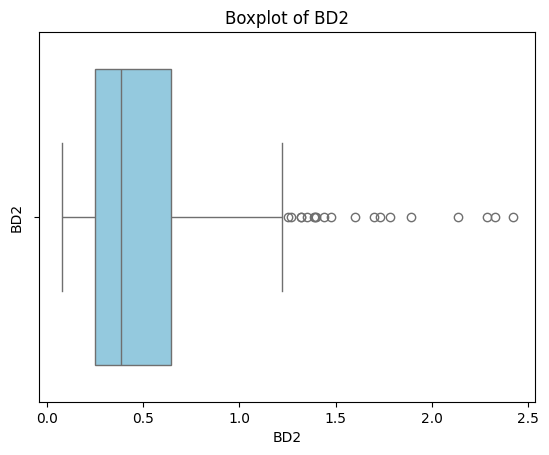

Number of outliers in Age: 12


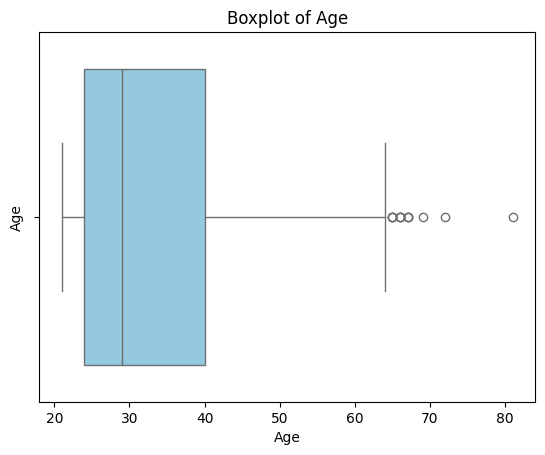

Number of outliers in Insurance: 0


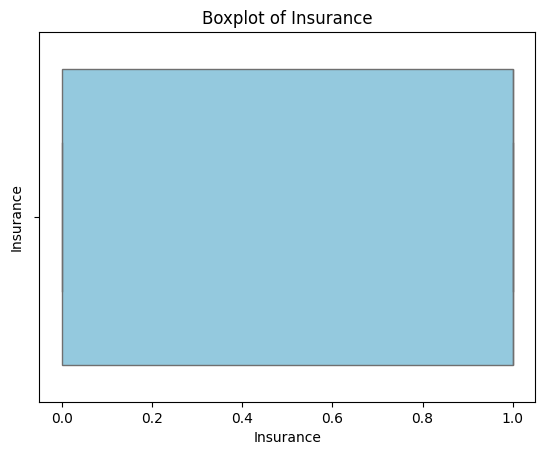

In [22]:
# Create a box plot by Iterating over each numerical column
for col in cols:
    sns.boxplot(data = train_dataset[col],whis=1.5, orient='h',palette=['skyblue', 'teal'])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

    # Get the outliers
    outliers = train_dataset[train_dataset[col] > train_dataset[col].quantile(0.75) + 1.5 * (train_dataset[col].quantile(0.75) - train_dataset[col].quantile(0.25))]


    # Print the number of outliers
    # Print the number of outliers
    num_outliers = len(outliers)
    print(f"Number of outliers in {col}: {num_outliers}")

    # Show the plot
    plt.show()

#### Bivariate Analysis

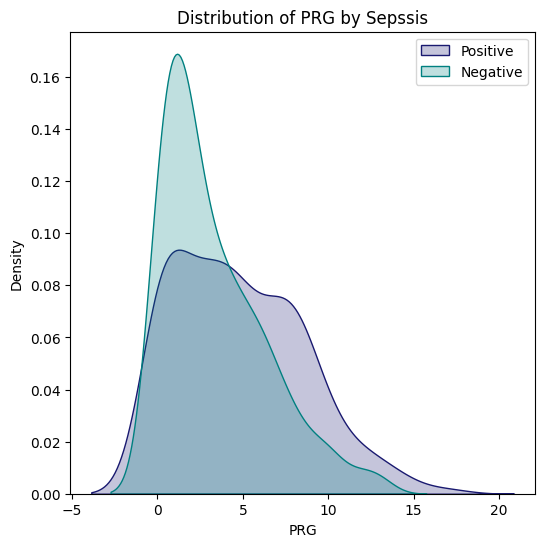

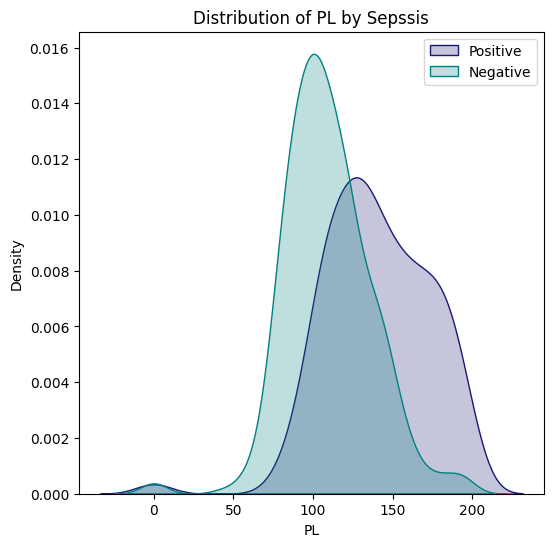

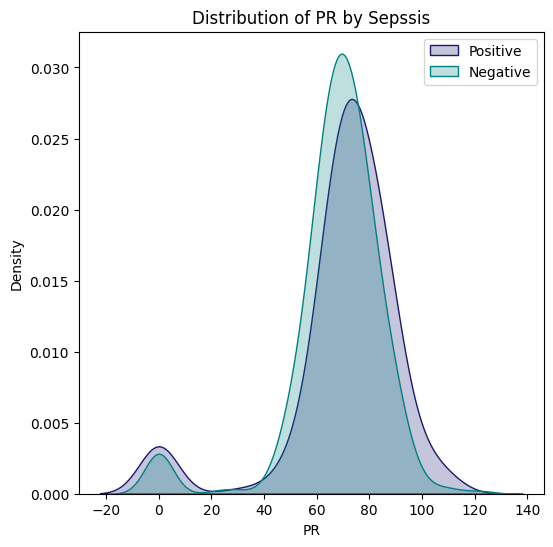

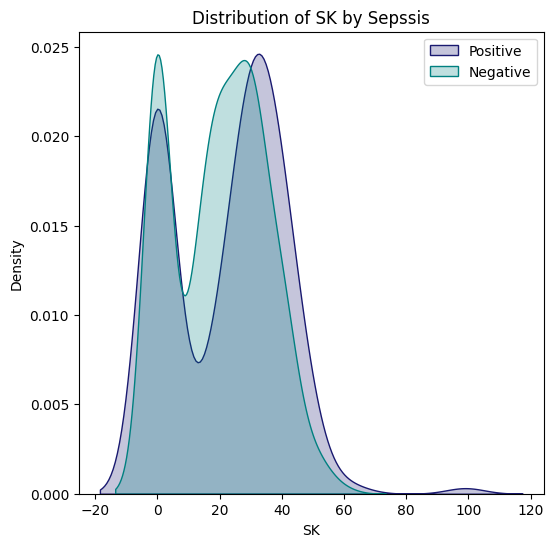

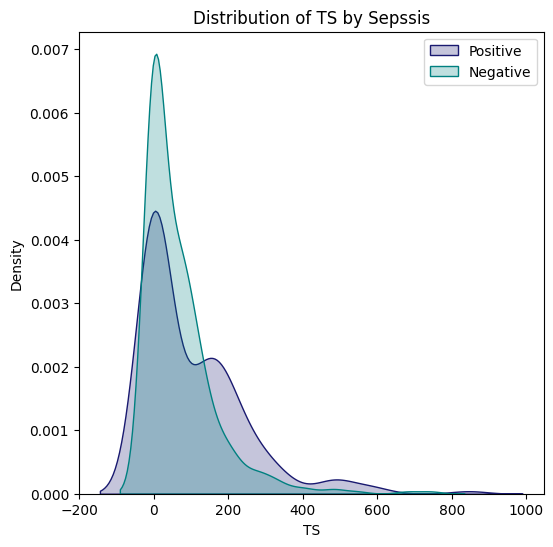

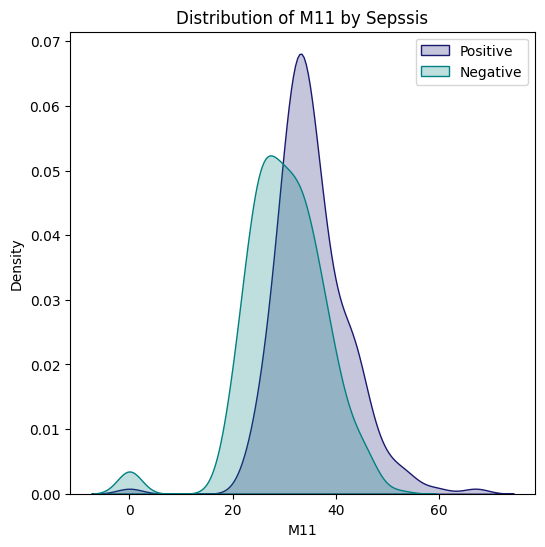

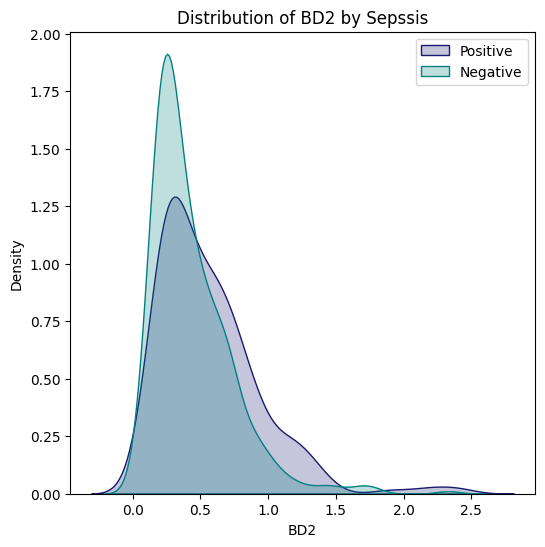

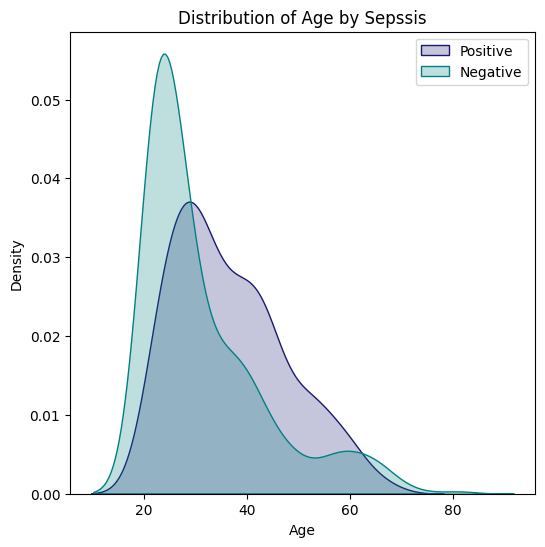

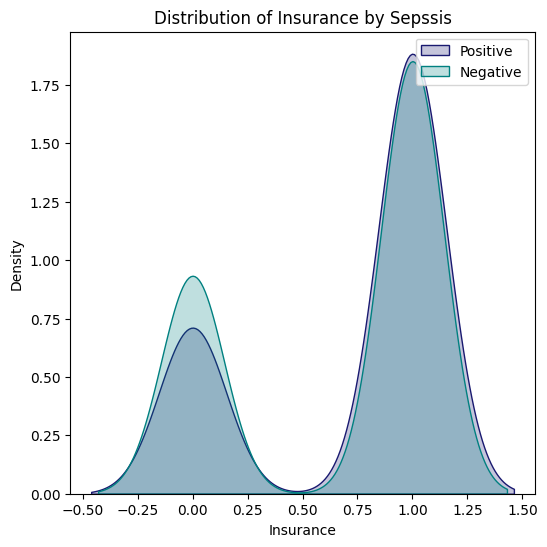

In [23]:
#create separate KDE plots for each column
for i in cols:
    plt.figure(figsize=(6, 6))
    
    
    # Separate the data based on those affected by sepsis
    positive_data = train_dataset[train_dataset['Sepssis'] == 'Positive'][i]
    negative_data = train_dataset[train_dataset['Sepssis'] == 'Negative'][i]

    # Plot each patient's distribution
    sns.kdeplot(positive_data, shade=True, label='Positive',  color='midnightblue')
    sns.kdeplot(negative_data, shade=True, label='Negative', color='teal')

    plt.title(f'Distribution of {i} by Sepssis')
    plt.legend()
    plt.show()

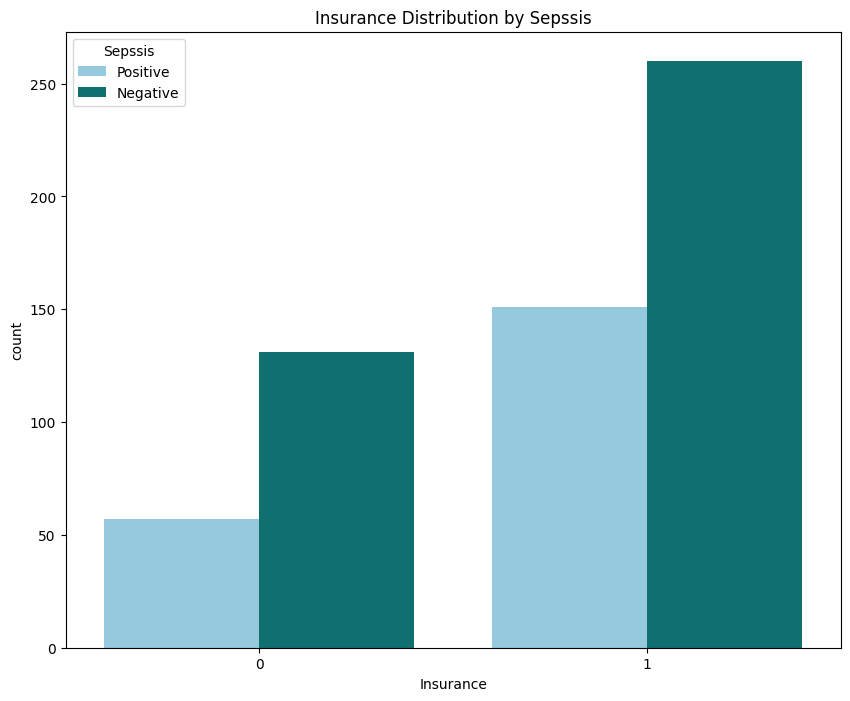

In [24]:
# Analysis for insurance column in relation to sepsis column
plt.figure(figsize=(10, 8))
sns.countplot(data=train_dataset, x='Insurance', hue='Sepssis' ,palette=['skyblue', 'teal'])
plt.title('Insurance Distribution by Sepssis')
plt.show()

In [25]:
# Define age bins
age_bins = [20,  40, 60,  80,  100]
age_labels = ["{0} - {1}".format(age_bins[i], age_bins[i + 1] - 1) for i in range(len(age_bins) - 1)]

# Create a new column 'Age Group' in your DataFrame
train_dataset['age_group'] = pd.cut(train_dataset['Age'], bins=age_bins, labels=age_labels, right=False)

# Display the counts of each age group
train_dataset['age_group'].value_counts()

age_group
20 - 39    443
40 - 59    129
60 - 79     26
80 - 99      1
Name: count, dtype: int64

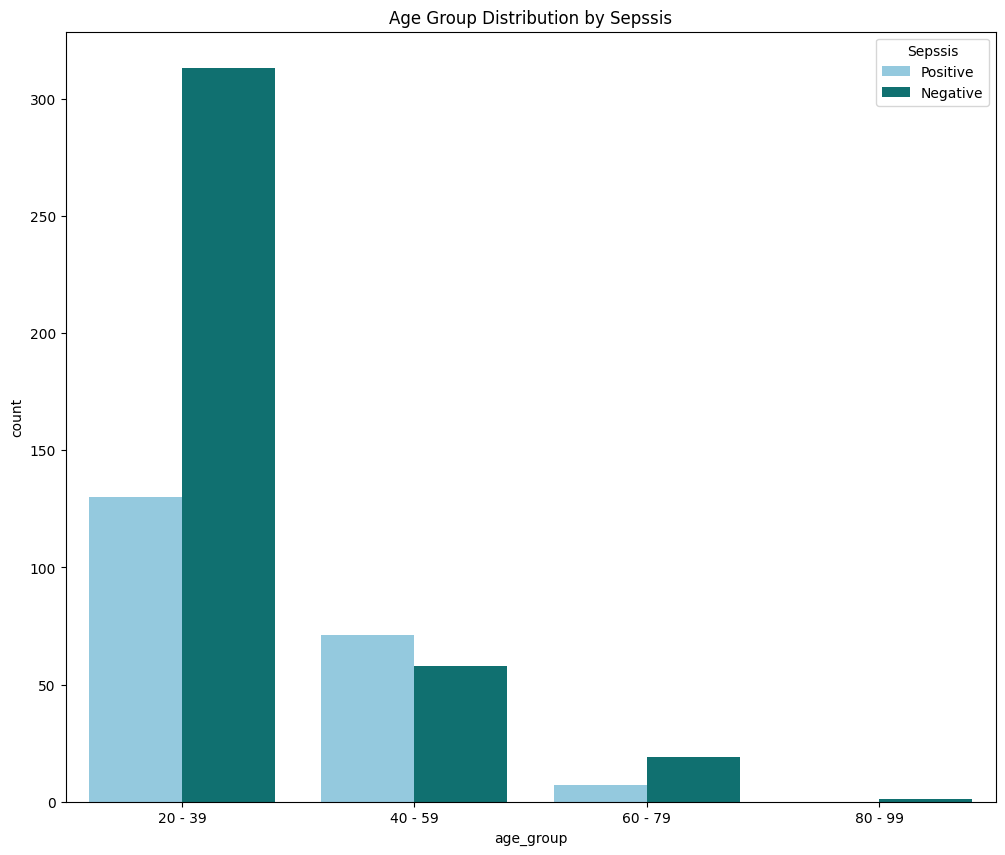

In [26]:
# Analysis for age_group column in relation to sepsis column
plt.figure(figsize=(12, 10))
sns.countplot(data=train_dataset, x='age_group', hue='Sepssis' ,palette=['skyblue', 'teal'])
plt.title('Age Group Distribution by Sepssis')
plt.show()

In [27]:
# Define bins and labels
bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

# Create a new column 'BMI Category' in your DataFrame
train_dataset['BMI_category'] = pd.cut(train_dataset['M11'], bins=bmi_bins, labels=bmi_labels, right=False)

# Display the counts of each BMI category
train_dataset['BMI_category'].value_counts()

BMI_category
Obese          372
Overweight     136
Normal          78
Underweight     13
Name: count, dtype: int64

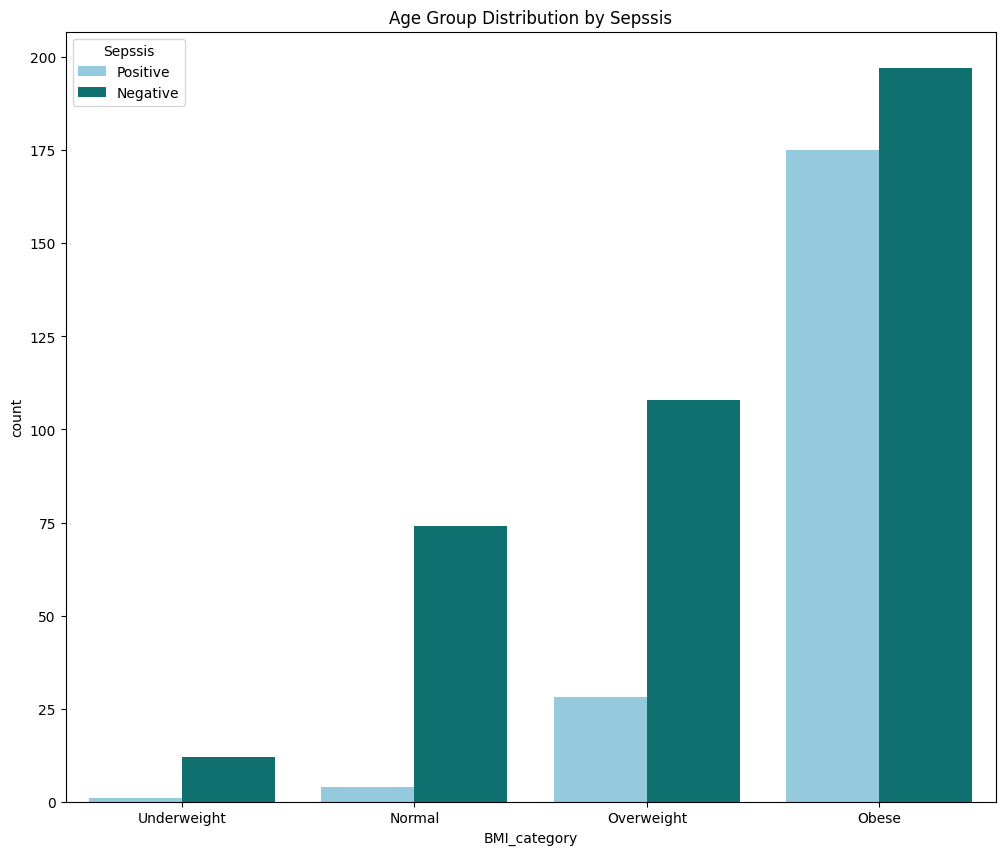

In [28]:
# Analysis for age_group column in relation to sepsis column
plt.figure(figsize=(12, 10))
sns.countplot(data=train_dataset, x='BMI_category', hue='Sepssis' ,palette=['skyblue', 'teal'])
plt.title('Age Group Distribution by Sepssis')
plt.show()

#### Multivariate Analysis

In [29]:
# Encoding the target variable
train_dataset['Sepssis_mapped'] = train_dataset['Sepssis'].map({'Negative': 0, 'Positive': 1})

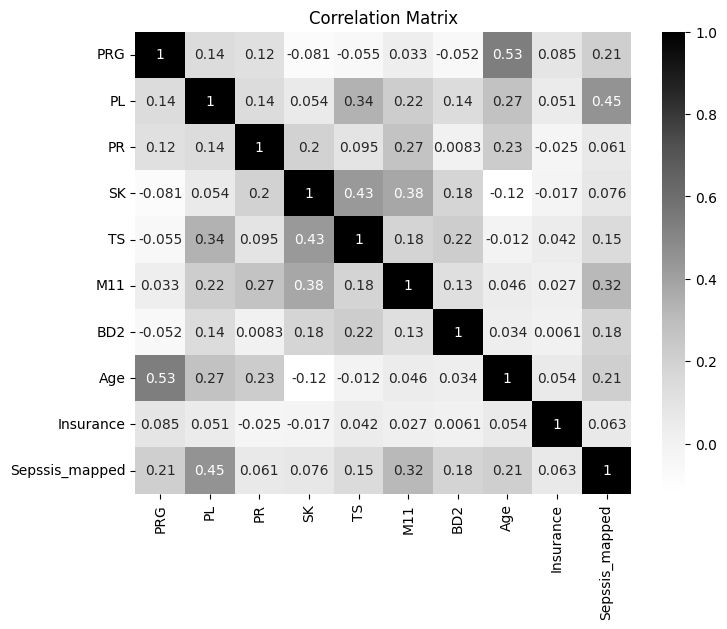

In [30]:
df_corr =train_dataset.corr(numeric_only=True)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data=df_corr, annot=True, cmap='Greys')
plt.title('Correlation Matrix')
plt.show()

> ### Key Insights from the EDA
- the dataset has no null values
- the dataset has no duplicates
- only the sepssis column is categorical 
- the summary statistics provided indicate that the variables have different scales, ranges, and levels of variability.
- The dataset exhibits an imbalance, where the number of negative sepsis cases surpasses that of positive sepsis cases.
- The count of patients with health insurance coverage exceeds the count of those without coverage. 


### 4. Testing the hypothesis

#### Null Hypothesis:

The mean Plasma glucose level (PRG) is not significantly different between patients who develop sepsis during their ICU stay and those who do not.

#### Alternative Hypothesis:

The mean Plasma glucose level (PRG) is significantly different between patients who develop sepsis during their ICU stay and those who do not.

In [31]:
prg_sepsis = train_dataset[train_dataset['Sepssis'] == 'Positive']['PRG']
prg_no_sepsis = train_dataset[train_dataset['Sepssis'] == 'Negative']['PRG']

# Perform t-test
t_statistic, p_value = ttest_ind(prg_sepsis, prg_no_sepsis, equal_var=False)

# Set significance level
alpha = 0.05

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Compare p-value to alpha
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in mean PRG between patients with and without sepsis.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in mean PRG between patients with and without sepsis.")

T-statistic: 4.842533902324343
P-value: 1.924247139438273e-06
Reject the null hypothesis. There is a significant difference in mean PRG between patients with and without sepsis.


### 5. Answering analytical questions

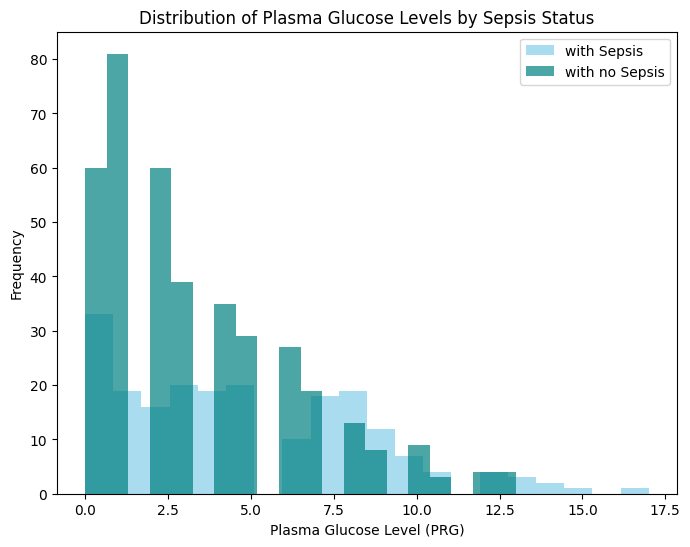

In [32]:
# 1. What is the average Plasma glucose level (PRG) among patients who develop sepsis compared to those who do not?

# Set up the figure
plt.figure(figsize=(8, 6))

# Plot histogram for patients with sepsis
plt.hist(prg_sepsis, bins=20, color='skyblue', alpha=0.7, label='with Sepsis')

# Plot histogram for patients without sepsis
plt.hist(prg_no_sepsis, bins=20, color='Teal', alpha=0.7, label='with no Sepsis')

# Add labels and title
plt.xlabel('Plasma Glucose Level (PRG)')
plt.ylabel('Frequency')
plt.title('Distribution of Plasma Glucose Levels by Sepsis Status')
plt.legend()

# Show plot
plt.show()

In [33]:
# 2.Are there any significant differences in Blood Pressure (PR), Body mass index (M11), or age between patients who develop sepsis and those who do not?

# Separate data into two groups based on 'Sepssis' values
sepsis_positive =train_dataset[train_dataset['Sepssis'] == 'Positive']
sepsis_negative =train_dataset[train_dataset['Sepssis'] == 'Negative']

# Perform independent samples t-tests for PR, M11, and Age
ttest_pr = stats.ttest_ind(sepsis_positive['PR'], sepsis_negative['PR'], equal_var=True)
ttest_m11 = stats.ttest_ind(sepsis_positive['M11'], sepsis_negative['M11'], equal_var=True)
ttest_age = stats.ttest_ind(sepsis_positive['Age'], sepsis_negative['Age'], equal_var=True)

# Print the results
print("Independent Samples T-Test Results:")
print("Blood Pressure (PR):")
print("  t-value:", ttest_pr.statistic)
print("  p-value:", ttest_pr.pvalue)
print("Body mass index (M11):")
print("  t-value:", ttest_m11.statistic)
print("  p-value:", ttest_m11.pvalue)
print("Age:")
print("  t-value:", ttest_age.statistic)
print("  p-value:", ttest_age.pvalue)

Independent Samples T-Test Results:
Blood Pressure (PR):
  t-value: 1.495353813655633
  p-value: 0.1353505282559576
Body mass index (M11):
  t-value: 8.134971813407034
  p-value: 2.397251962664531e-15
Age:
  t-value: 5.254202967191448
  p-value: 2.0718778891881853e-07


- Blood Pressure (PR):
Interpretation: The t-value of 1.4954 indicates a moderate-sized difference in Blood Pressure (PR) between patients with and without sepsis. However, the p-value of 0.1354 is greater than the common significance level of 0.05, suggesting that we do not have enough evidence to reject the null hypothesis. Therefore, we cannot conclude that there is a significant difference in Blood Pressure (PR) between the two groups.

- Body mass index (M11):
Interpretation: The t-value of 8.1350 indicates a large difference in Body mass index (M11) between patients with and without sepsis. Additionally, the extremely small p-value of approximately 2.4e-15 suggests very strong evidence against the null hypothesis. Therefore, we can conclude that there is a significant difference in Body mass index (M11) between the two groups.

- Age:
Interpretation: The t-value of 5.2542 indicates a moderate to large difference in Age between patients with and without sepsis. Similarly, the very small p-value of approximately 2.1e-07 suggests very strong evidence against the null hypothesis. Therefore, we can conclude that there is a significant difference in Age between the two groups.

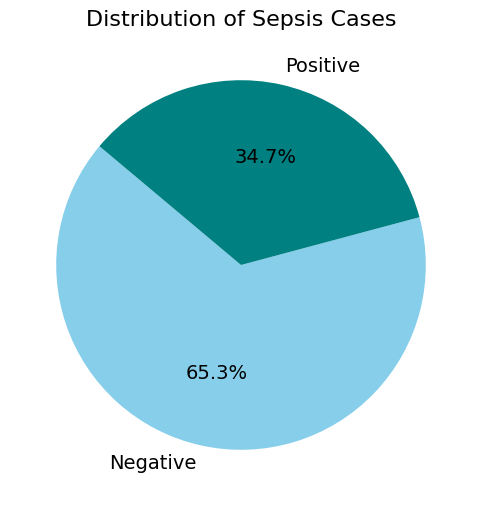

Prevalence of Sepsis: 34.72%


In [34]:
# 3.What is the prevalence of sepsis among the patient population, & identify factors contributing to the tendency of developing sepsis?

sep_df = train_dataset['Sepssis'].value_counts()
prevalence = sep_df[1] / train_dataset.shape[0] * 100

plt.figure(figsize=(12, 6))
plt.pie(sep_df, labels=sep_df.index, colors=['Skyblue', 'Teal'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
plt.title('Distribution of Sepsis Cases', fontsize=16)
plt.show()

print(f"Prevalence of Sepsis: {prevalence:.2f}%")


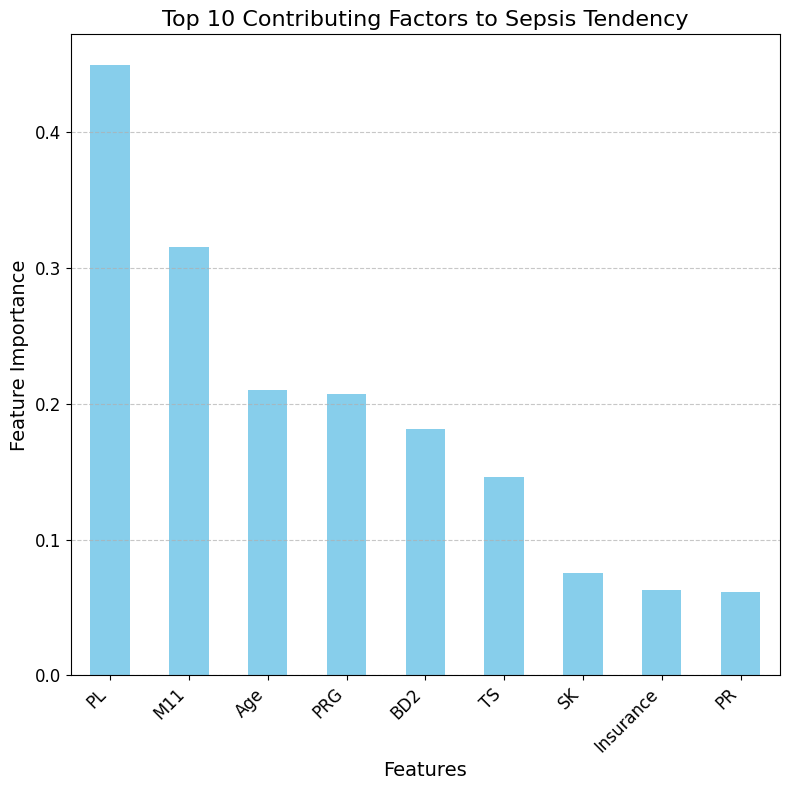

In [35]:
# Identify contributing factors using feature importance
features = train_dataset[cols]
target = train_dataset['Sepssis_mapped']

feature_importance = features.corrwith(target)
top_features = feature_importance.abs().nlargest(10)

plt.figure(figsize=(8, 8))
top_features.plot(kind='bar', color='skyblue')
plt.title('Top 10 Contributing Factors to Sepsis Tendency', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Feature Importance', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

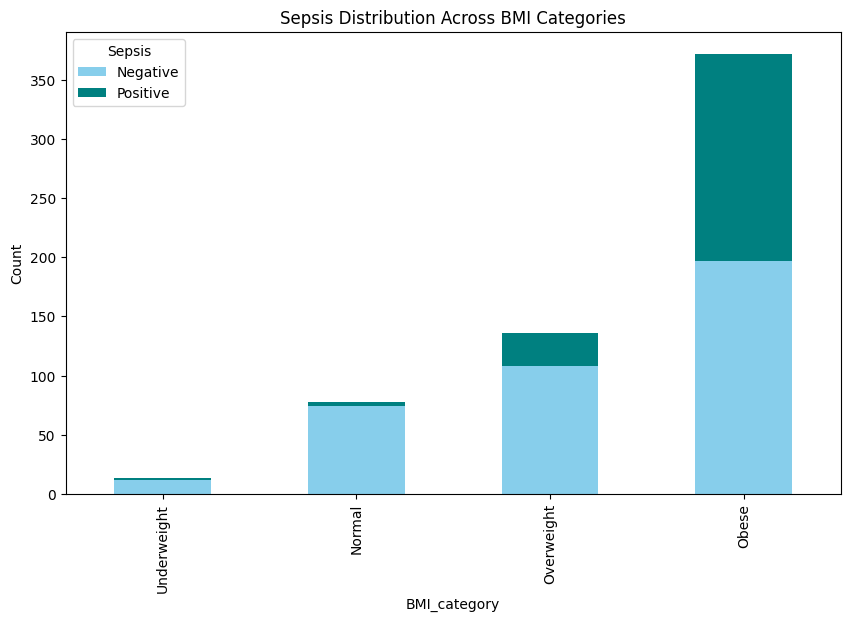

Chi-square value: 71.22805545724869
P-value: 2.3295048715621714e-15


In [36]:
# 4.Is there a significant correlation between a patient's body mass and their susceptibility to sepsis, and can body mass be considered a potential risk factor for sepsis development?

# Create a contingency table for BMI categories and sepsis status
contingency_table = pd.crosstab(train_dataset['BMI_category'], train_dataset['Sepssis'])

# Plot stacked bar chart
contingency_table.plot(kind='bar', stacked=True, color=['Skyblue', 'Teal'], figsize=(10, 6))
plt.title('Sepsis Distribution Across BMI Categories')
plt.xlabel('BMI_category')
plt.ylabel('Count')
plt.legend(title='Sepsis')
plt.show()

# Calculate chi-square value and p-value
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square value: {chi2}")
print(f"P-value: {p_value}")

### 6. Data Preparation

In [37]:
train_dataset.columns

Index(['ID', 'PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance',
       'Sepssis', 'age_group', 'BMI_category', 'Sepssis_mapped'],
      dtype='object')

In [38]:
train_dataset = train_dataset.drop(columns=['age_group','Sepssis_mapped','BMI_category','ID'], axis=1)

train_dataset.head()



,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,6,148,72,35,0,33.6,0.627,50,0,Positive
1,1,85,66,29,0,26.6,0.351,31,0,Negative
2,8,183,64,0,0,23.3,0.672,32,1,Positive
3,1,89,66,23,94,28.1,0.167,21,1,Negative
4,0,137,40,35,168,43.1,2.288,33,1,Positive


#### Trim the outliers

In [39]:
numerical_features = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

# Creating a copy of the DataFrame to preserve the original data
df_trim = train_dataset.copy()

# Calculating the IQR
Q1 = train_dataset[numerical_features].quantile(0.25)
Q3 = train_dataset[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Creating a mask to identify outliers
outlier_mask = ((train_dataset[numerical_features] < (Q1 - 1.5 * IQR)) | (train_dataset[numerical_features] > (Q3 + 1.5 * IQR)))

# Removing outliers
df_trim = df_trim[~outlier_mask.any(axis=1)]

# Display the shape of the cleaned dataset
print("Original shape:", train_dataset.shape)
print("Shape after removing outliers:", df_trim.shape)

Original shape: (599, 10)
Shape after removing outliers: (493, 10)


In [40]:
# Define your features (X) and target variable (y)
X = df_trim.drop('Sepssis', axis=1)
y = df_trim['Sepssis']

#### create a pipeline

In [41]:
input_features = X.columns
preprocessor = ColumnTransformer(
    transformers= [
        ('scaler', StandardScaler(),input_features),
        ('log_transformation', FunctionTransformer(np.log1p), input_features)
    ]
)

In [42]:
# Check the class distribution in the training set before balancing
print("Class distribution before balancing:")
print(y.value_counts())

Class distribution before balancing:
Sepssis
Negative    337
Positive    156
Name: count, dtype: int64


In [43]:
# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# Check the class distribution after balancing
balanced_class_counts = y_train_resampled.value_counts()
print("\nClass distribution in the balanced training set:")
print(balanced_class_counts)


Class distribution in the balanced training set:
Sepssis
Positive    337
Negative    337
Name: count, dtype: int64


In [44]:
# Split the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)
print("Shape of the Training Set (X_train, y_train):", X_train.shape, y_train.shape)
print("Shape of the Evaluation Set (X_eval, y_eval):", X_eval.shape, y_eval.shape)

Shape of the Training Set (X_train, y_train): (539, 9) (539,)
Shape of the Evaluation Set (X_eval, y_eval): (135, 9) (135,)


In [45]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_eval_encoded = encoder.transform(y_eval)

#### Modelling

In [46]:
# List of models
models = [SVC(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(),
          XGBClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), LogisticRegression()]

metrics = []

# Iterating over models
for model in models:
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train_encoded)

    # Predict using the evaluation set
    y_pred = pipeline.predict(X_eval)

    # Calculate the metrics
    acc = accuracy_score(y_eval_encoded, y_pred)
    f1 = f1_score(y_eval_encoded, y_pred)
    roc = roc_auc_score(y_eval_encoded, y_pred)
    pr = precision_score(y_eval_encoded, y_pred)
    rc = recall_score(y_eval_encoded, y_pred)

     # Append the metrics to the list
    metrics.append({"Model": model.__class__.__name__,
                    "Accuracy Score": acc,
                    "F1 Score": f1,
                    "ROC AUC Score": roc,
                    "Precision Score": pr,
                    "Recall Score": rc})

# Creating a DataFrame for the overall performance
overall = pd.DataFrame(metrics)
overall = overall.sort_values(by="Accuracy Score", ascending=False)
overall_styled = overall.style.background_gradient(cmap="Spectral")
overall_styled

,Model,Accuracy Score,F1 Score,ROC AUC Score,Precision Score,Recall Score
3,RandomForestClassifier,0.874074,0.872180,0.874012,0.878788,0.865672
4,XGBClassifier,0.859259,0.861314,0.859416,0.842857,0.880597
5,GradientBoostingClassifier,0.822222,0.820896,0.822212,0.820896,0.820896
6,AdaBoostClassifier,0.792593,0.777778,0.792142,0.830508,0.731343
2,DecisionTreeClassifier,0.785185,0.775194,0.784899,0.806452,0.746269
1,GaussianNB,0.770370,0.755906,0.769974,0.800000,0.716418
0,SVC,0.762963,0.750000,0.762621,0.786885,0.716418
7,LogisticRegression,0.748148,0.734375,0.747805,0.770492,0.701493


In [47]:
models = [SVC(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(),
          XGBClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), LogisticRegression()]

for model in models:
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Fit the model
    pipeline.fit(X_train, y_train_encoded)

    # Predict on the test set
    y_pred = pipeline.predict(X_eval)

    # Print the classification report
    print("Model: ", model.__class__.__name__)
    print("Classification Report: \n", classification_report(y_eval_encoded, y_pred))

    # Generate and display the confusion matrix
    fig = px.imshow(confusion_matrix(y_eval_encoded, y_pred), color_continuous_scale='tropic',
                    title="Confusion Matrix of " + model.__class__.__name__,
                    labels=dict(x="Predicted", y="Actual", color="Counts"),
                    color_continuous_midpoint=0.8, width=400, height=400,
                    template="plotly_dark", text_auto=True)
    fig.show()

    print("----------------------------------------------------------")

Model:  SVC
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.81      0.77        68
           1       0.79      0.72      0.75        67

    accuracy                           0.76       135
   macro avg       0.77      0.76      0.76       135
weighted avg       0.76      0.76      0.76       135



----------------------------------------------------------
Model:  GaussianNB
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.82      0.78        68
           1       0.80      0.72      0.76        67

    accuracy                           0.77       135
   macro avg       0.77      0.77      0.77       135
weighted avg       0.77      0.77      0.77       135



----------------------------------------------------------
Model:  DecisionTreeClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.82      0.80        68
           1       0.81      0.76      0.78        67

    accuracy                           0.79       135
   macro avg       0.79      0.79      0.79       135
weighted avg       0.79      0.79      0.79       135



----------------------------------------------------------
Model:  RandomForestClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        68
           1       0.87      0.87      0.87        67

    accuracy                           0.87       135
   macro avg       0.87      0.87      0.87       135
weighted avg       0.87      0.87      0.87       135



----------------------------------------------------------
Model:  XGBClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        68
           1       0.84      0.88      0.86        67

    accuracy                           0.86       135
   macro avg       0.86      0.86      0.86       135
weighted avg       0.86      0.86      0.86       135



----------------------------------------------------------
Model:  GradientBoostingClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.82      0.82        68
           1       0.82      0.82      0.82        67

    accuracy                           0.82       135
   macro avg       0.82      0.82      0.82       135
weighted avg       0.82      0.82      0.82       135



----------------------------------------------------------
Model:  AdaBoostClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.85      0.81        68
           1       0.83      0.73      0.78        67

    accuracy                           0.79       135
   macro avg       0.80      0.79      0.79       135
weighted avg       0.80      0.79      0.79       135



----------------------------------------------------------
Model:  LogisticRegression
Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        68
           1       0.77      0.70      0.73        67

    accuracy                           0.75       135
   macro avg       0.75      0.75      0.75       135
weighted avg       0.75      0.75      0.75       135



----------------------------------------------------------


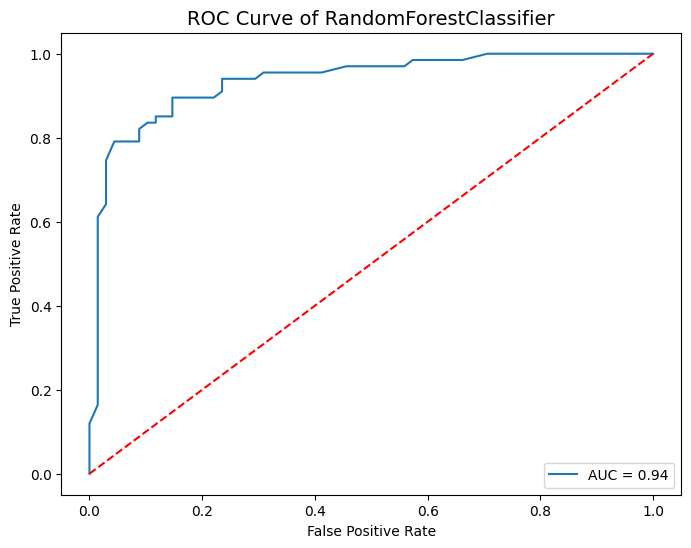

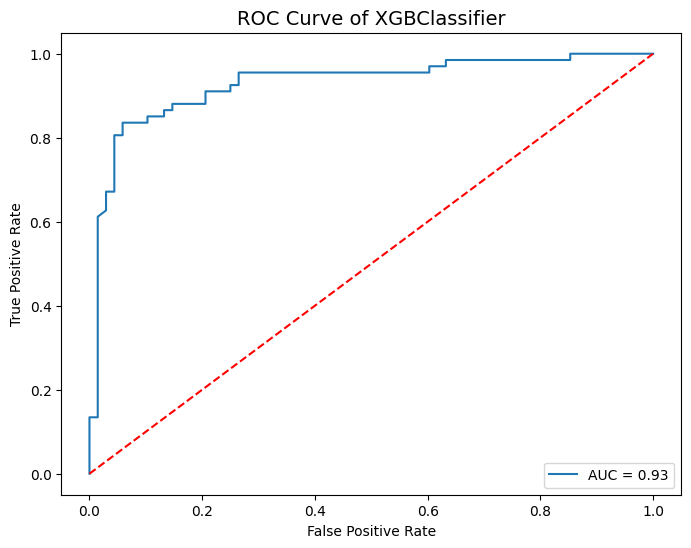

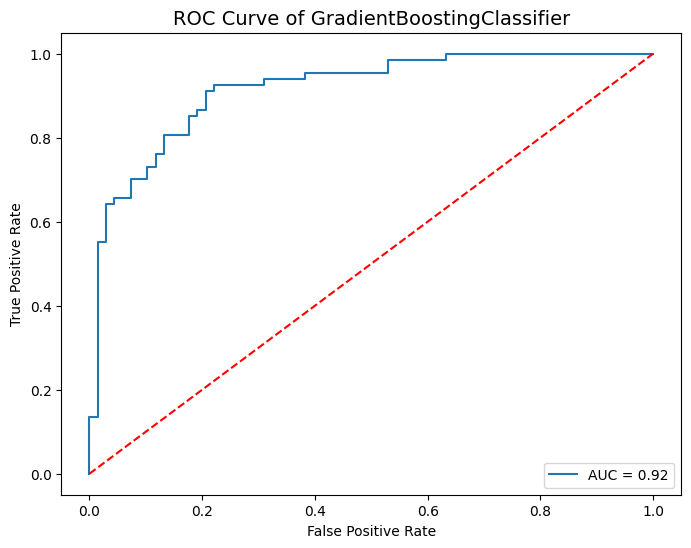

In [48]:
models =[RandomForestClassifier(), XGBClassifier(), GradientBoostingClassifier()]

for model in models:
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Fit the model on your training data before making predictions
    pipeline.fit(X_train, y_train_encoded)
    
    # ROC Curve:
    y_prob = pipeline.predict_proba(X_eval)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_eval_encoded, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label="AUC = %0.2f" % roc_auc_score(y_eval_encoded, y_prob))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.legend(loc='lower right')
    plt.title("ROC Curve of " + model.__class__.__name__, size=14)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [49]:
# Define models
rfc = RandomForestClassifier()
xgb = XGBClassifier()

# Define hyperparameter grids for each model

rfc_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
# Create lists of models and their corresponding parameter grids
models = [rfc, xgb]
params = [rfc_params, xgb_params]

 #Perform grid search for each model
for model, param_grid in zip(models, params):
    grid_cv = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, verbose=2)
    grid_cv.fit(X_train, y_train_encoded)
    
    print(model.__class__.__name__, "Best params:", grid_cv.best_params_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
RandomForestClassifier Best params: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBClassifier Best params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}


In [50]:
# Final models:
rfc = RandomForestClassifier(bootstrap=True, max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=100)
xgb = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=300)

models = [rfc,xgb]

overral=pd.DataFrame(columns=["Model","Accuracy Score","F1 Score","ROC AUC Score","precision_score","recall_score"])
for model in models:
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
       
    ])
    pipeline.fit(X_train,y_train_encoded)
    y_pred=pipeline.predict(X_eval)
    acc=accuracy_score(y_eval_encoded,y_pred)
    f1=f1_score(y_eval_encoded,y_pred)
    roc=roc_auc_score(y_eval_encoded,y_pred)
    pr=precision_score(y_eval_encoded,y_pred)
    rc=recall_score(y_eval_encoded,y_pred)
    
    overral=overral._append({"Model":model.__class__.__name__,
                            "Accuracy Score":acc,
                            "F1 Score":f1,
                            "ROC AUC Score":roc,
                            "precision_score":pr,
                            "recall_score":rc},ignore_index=True)

overral=overral.sort_values(by="Accuracy Score",ascending=False)
overral=overral.style.background_gradient(cmap="Spectral")
overral

,Model,Accuracy Score,F1 Score,ROC AUC Score,precision_score,recall_score
0,RandomForestClassifier,0.881481,0.880597,0.881475,0.880597,0.880597
1,XGBClassifier,0.851852,0.848485,0.851734,0.861538,0.835821


In [51]:
models = [rfc,xgb]
for model in models:
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train_encoded)
    y_pred = pipeline.predict(X_eval)
    print("Model: ", model.__class__.__name__)
    print("Classification Report: \n", classification_report(y_eval_encoded, y_pred))
    print("Model: ",model.__class__.__name__)
    fig=px.imshow(confusion_matrix(y_eval_encoded,y_pred),color_continuous_scale='tropic',title="Confusion Matrix of "+model.__class__.__name__,
              labels=dict(x="Predicted",y="Actual",color="Counts"),color_continuous_midpoint=0.8,
              width=400,height=400,template="plotly_dark",text_auto=True)
    fig.show()
    print("----------------------------------------------------------")

Model:  RandomForestClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        68
           1       0.84      0.88      0.86        67

    accuracy                           0.86       135
   macro avg       0.86      0.86      0.86       135
weighted avg       0.86      0.86      0.86       135

Model:  RandomForestClassifier


----------------------------------------------------------
Model:  XGBClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.87      0.86        68
           1       0.86      0.84      0.85        67

    accuracy                           0.85       135
   macro avg       0.85      0.85      0.85       135
weighted avg       0.85      0.85      0.85       135

Model:  XGBClassifier


----------------------------------------------------------


In [52]:
# Final models
rfc = RandomForestClassifier(bootstrap=True, max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=100)
xgb = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=300)

models = [rfc, xgb]

# Create a list to store cross-validation results
cv_results = []

# Specify the cross-validation strategy (StratifiedKFold for classification)
cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)

for model in models:
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=cv, scoring='accuracy')
    
    # Store cross-validation results
    cv_results.append({
        'Model': model.__class__.__name__,
        'Cross-Validation Scores': scores
    })

# Display cross-validation results
for result in cv_results:
    print(f"Model: {result['Model']}")
    print(f"Cross-Validation Scores: {result['Cross-Validation Scores']}")
    print(f"Mean Accuracy: {result['Cross-Validation Scores'].mean():.4f}")
    print("----------------------------------------------------------")

Model: RandomForestClassifier
Cross-Validation Scores: [0.78703704 0.86111111 0.84259259 0.80555556 0.85046729]
Mean Accuracy: 0.8294
----------------------------------------------------------
Model: XGBClassifier
Cross-Validation Scores: [0.78703704 0.83333333 0.78703704 0.78703704 0.80373832]
Mean Accuracy: 0.7996
----------------------------------------------------------


#### Save the pipeline and encoder

In [53]:
# Specify the absolute path to the "assets" folder
Assets = os.path.abspath('../building-machine-learning-APIs-with-FASTAPI/models')

# Save the pipeline using joblib for RandomForestClassifier
rfc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rfc)
])
rfc_pipeline.fit(X_train, y_train_encoded)
joblib.dump(rfc_pipeline, os.path.join(Assets, f'{rfc.__class__.__name__}_pipeline.joblib'))

# Save the pipeline using joblib for XGBClassifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])
xgb_pipeline.fit(X_train, y_train_encoded)
joblib.dump(xgb_pipeline, os.path.join(Assets, f'{xgb.__class__.__name__}_pipeline.joblib'))

# Save the encoder using joblib in the "assets" folder
joblib.dump(encoder, os.path.join(Assets, 'encoder.joblib'))

['c:\\Users\\sumei\\OneDrive\\desktop\\deedah\\building-machine-learning-APIs-with-FASTAPI\\models\\encoder.joblib']